# Field-Level Bayesian Inference with N-body Simulations

<a href="https://colab.research.google.com/github/ASKabalan/Tutorials/blob/main/BDL2025/Exercises/02_Intermediate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to the advanced part of this tutorial!
In this notebook, we'll move beyond summary statistics and step into **field-level inference**, where the **entire matter field** is used to constrain cosmological parameters.

We'll use:

* `jaxpm` for forward N-body simulation of structure formation.
* `NumPyro` for modeling and defining the **prior over initial conditions**.
* `BlackJAX` to perform gradient-based sampling in **high-dimensional latent spaces**.

This notebook demonstrates:

* How to define and run a **forward model** using N-body physics.
* How to express **latent fields** and **cosmological parameters** as Bayesian variables.
* How to plug NumPyro models into **BlackJAX samplers** for scalable inference.



In [1]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn

## Forward Simulation with `jaxpm`

We begin by simulating the **nonlinear evolution of the matter field** using an N-body model. This is done via [`jaxpm`](https://github.com/DifferentiableUniverseInitiative/jaxpm), a fast and differentiable particle mesh simulator.

In this setup:

* We define a **power spectrum** based on cosmological parameters `Ω_c` and `σ₈`.
* We generate **initial conditions** using this power spectrum.
* We apply **Lagrangian Perturbation Theory (LPT)** to initialize displacements.
* We evolve the particles forward in time using **ODE integration**.

This function will serve as our **simulator**: given parameters, it outputs the final state of the universe. Later, we'll use this in a probabilistic context to perform inference over both cosmological parameters and the initial field.


In [2]:
mesh_shape = [64, 64, 64]
box_size = [64., 64., 64.]
snapshots = jnp.array([0.1, 0.5, 1.0])

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions and particles
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    # Initial displacement
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)

    # Return the simulation volume at requested timesteps
    return initial_conditions ,  particles + dx , res[0]

In [3]:
initial_conditions , lpt_particles , ode_particles = run_simulation(0.25, 0.8)

/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


##  Visualizing the Simulated Density Field

Let’s take a look at the output of the forward model.

* We paint the particle distributions onto a 3D mesh using **CIC (Cloud-In-Cell)** interpolation.
* We then visualize slices of the **log-density field** at different stages:

  * The **initial conditions**
  * The field after **LPT displacement**
  * The evolved field at later snapshots

This gives us a qualitative sense of the structure formation process over cosmic time.



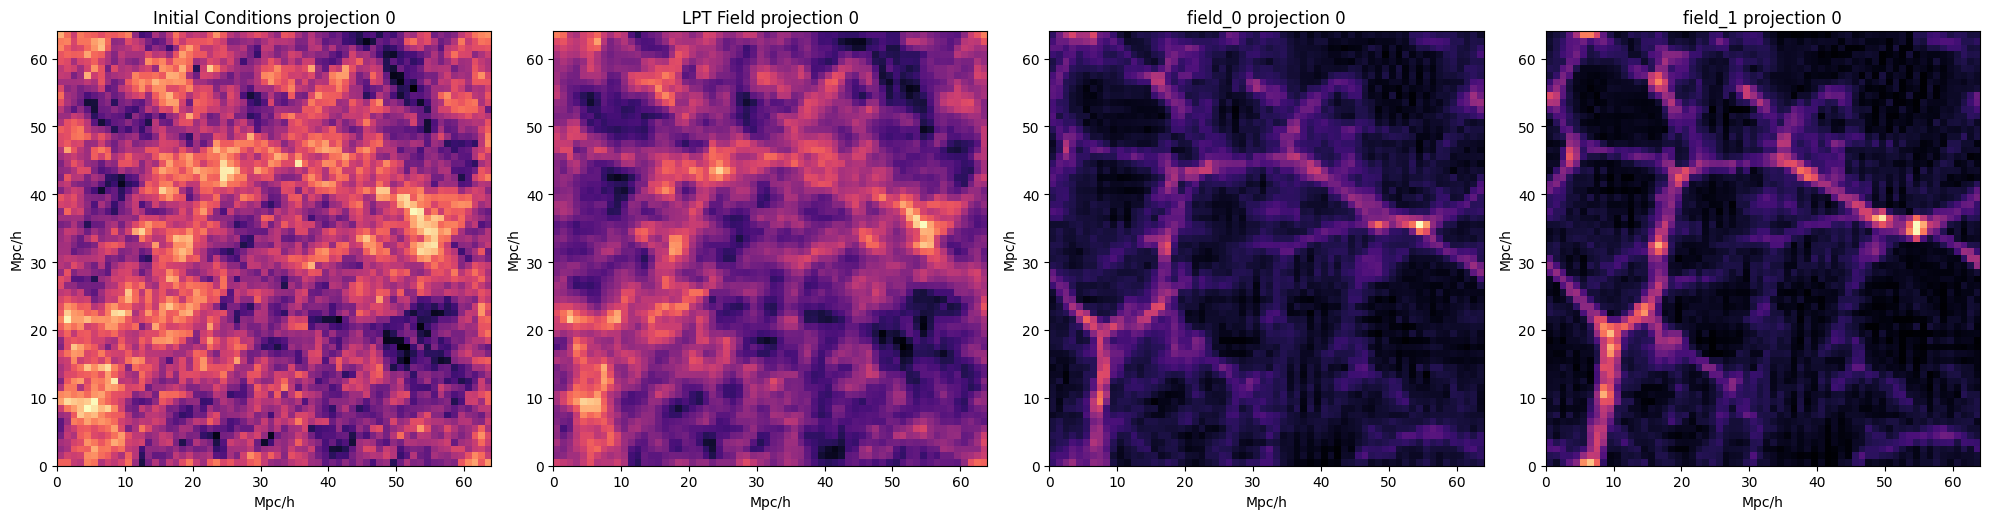

In [4]:
from jaxpm.plotting import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : jnp.log10(cic_paint(jnp.zeros(mesh_shape) ,lpt_particles) + 1)}
for i , field in enumerate(ode_particles[1:]):
    fields[f"field_{i}"] = jnp.log10(cic_paint(jnp.zeros(mesh_shape) , field)+1)
plot_fields_single_projection(fields ,  project_axis=1)


## Part 1: Inference of Initial Conditions from Simulated Fields

In this exercise, you’ll take the role of a "Bayesian detective."

### Your task:

1. **Generate a realization** of initial conditions using the power spectrum from a fixed cosmology.
2. Use a forward model (e.g., **LPT**) to simulate the final field.
3. Then, **define a NumPyro model** where the initial conditions are treated as **latent parameters**.
4. Try to **recover the original initial conditions** via Bayesian inference.

> ✅ The goal is to explore how well the field can constrain the initial state — and gain hands-on experience defining models with **high-dimensional latent spaces**.


In [5]:
import jax.numpy as jnp
import jax_cosmo as jc

from jaxpm.distributed import fft3d, ifft3d, normal_field
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second)
from jaxpm.kernels import (PGD_kernel, fftk, gradient_kernel,
                           invlaplace_kernel, longrange_kernel)
from jaxpm.painting import cic_paint, cic_paint_dx, cic_read, cic_read_dx
import numpyro.distributions as dist
import numpyro
from numpyro.handlers import seed , trace
import numpy as np
import matplotlib.pyplot as plt


## Sampling Initial Conditions as Latent Variables

To do inference over the **initial conditions**, we need to define them as **latent variables** inside our NumPyro model.

In this step, you'll implement a function that:

* Samples a standard normal random field in 3D.
* Applies a power spectrum transformation using the cosmology.
* Produces a linear field consistent with the desired **power spectrum**.

> 💡 This function can be reused as a **Bayesian prior** for simulations using LPT or full N-body methods.

You'll use this in your NumPyro model to sample initial conditions instead of cosmological parameters.



In [6]:
def sample_linear_field(mesh_shape, box_size, cosmo, sharding=None):
    """
    Generate initial conditions.
    """
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    # Initialize a random field with one slice on each gpu
    field =  numpyro.sample("normal", dist.Normal(0, 1), sample_shape=tuple(mesh_shape))
    field = fft3d(field)
    kvec = fftk(field)
    kmesh = sum((kk / box_size[i] * mesh_shape[i])**2
                for i, kk in enumerate(kvec))**0.5
    pkmesh = pk_fn(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
        box_size[0] * box_size[1] * box_size[2])

    field = field * (pkmesh)**0.5
    field = ifft3d(field)
    return field


## Defining a NumPyro Model with Initial Conditions

In this step, we define a minimal **Bayesian model** where the only latent variable is the **initial condition field**.

* We fix the cosmology (Ω<sub>c</sub>, σ₈) for now.
* We use `sample_linear_field` to sample a 3D initial field from a prior consistent with the power spectrum.
* The initial condition field is stored using `numpyro.deterministic` so we can inspect it later.

This is the core of **field-level inference**—treating the full 3D field as a latent variable.



/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


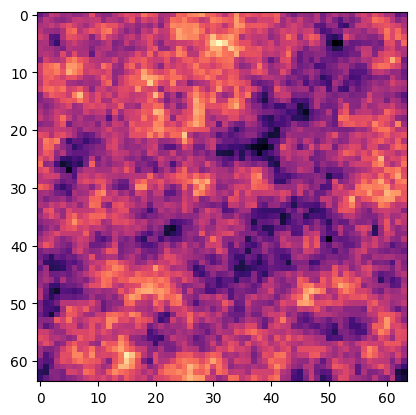

In [7]:
def model(obs=None):

    cosmo = jc.Planck15(Omega_c=0.25, sigma8=0.8)
    field = sample_linear_field(mesh_shape, box_size, cosmo)
    numpyro.deterministic("IC", field)

seeded_model = seed(model, rng_seed=10)
traced_model = trace(seeded_model).get_trace()

plt.imshow(traced_model['IC']['value'][:16].sum(axis=0), cmap='magma')


## ✍️ Exercise: Field Inference with NumPyro

Your task:

1. **Create Initial Conditions**

   * Use the `sample_linear_field` function with a **fiducial cosmology** (`Omega_c=0.25`, `sigma8=0.8`).
   * Fix the random seed to ensure reproducibility.

2. **Simulate Observations**

   * Use `condition` and `trace` (as in the previous notebook) to **generate an observed initial condition** from the model.

3. **Do Inference**

   * Remove the conditioning.
   * Use NumPyro with NUTS to **infer the latent field** based on the simulated observations.

Optional:

* Visualize and compare the inferred field with the ground truth.

Let’s see how well Bayesian inference can reconstruct a 3D initial condition!


#  Exercise: Add Cosmological Parameters to Inference

So far, you've been inferring only the **initial conditions** of the simulation, assuming fixed cosmological parameters (`Omega_c`, `sigma8`).

### 🎯 Task:

Modify your model to also **sample**:

```python
Omega_c = numpyro.sample("Omega_c", dist.Uniform(0.2, 0.4))
sigma8 = numpyro.sample("sigma8", dist.Uniform(0.6, 1.0))
```

Then:

* Use them to define the cosmology object:
  `cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)`
* Pass `cosmo` into your simulator
* Perform joint inference over both the cosmological parameters and the initial conditions

# Exercise: Compare Inference with LPT vs. ODE Forward Models

The simulation you ran earlier uses **ODE integration** to evolve the field.

But there's a faster approximation: **LPT (Lagrangian Perturbation Theory)**.

### 🎯 Task:

* Replace the forward simulator with the `lpt()` displacement field (instead of solving the ODE)
* Keep the same inference pipeline
* Compare the posterior over the initial conditions

```python
dx, p, _ = lpt(cosmo, initial_conditions, particles, a=1.0)
observable = jnp.log1p(cic_paint(jnp.zeros(mesh_shape), particles + dx))
```